# Hénon–Heiles system


The Hénon–Heiles system is a Hamiltonian system decribing motion of a star around a galactic center. The Hénon–Heiles Hamiltonian is defined as follows:

$$
\mathcal{H}[p,x,y] = \frac{p_x^2}{2} + \frac{p_y^2}{2} + \frac{1}{2}(x^2+y^2)+ \lambda (x^2y-\frac{1}{3}y^3)
$$

By the following equations holding for all Hamiltonian systems, one can derive the differential equation describing our system.
$$
\begin{aligned}
\dot q &= \frac{\partial \mathcal{H}}{\partial p}(q,p) \\
\dot p &= -\frac{\partial \mathcal{H}}{\partial q}(q,p) 
\end{aligned}
$$

We have

$$
\begin{aligned}
\dot x &= \frac{\partial \mathcal{H}}{\partial p_x}(x,y,p) = p_x \\
\dot y &= \frac{\partial \mathcal{H}}{\partial p_y}(x,y,p) = p_y \\
\dot p_x &= -\frac{\partial \mathcal{H}}{\partial x}(q,p) = -x-2\lambda xy \\
\dot p_y &= -\frac{\partial \mathcal{H}}{\partial y}(q,p) = -y-\lambda (x^2-y^2)
\end{aligned}
$$


We can rewrite the Henon-Heiles equation on the Pseudo-Hamiltonian system form:

$$
\frac{d u}{dt} = (S-R) \nabla H(u) + F(u,t) 
$$

Where $u = (x,y,p_x,p_y)^T$.

We have $R=F=0$, as we do not have any dissipation or external forces working on the system. We thus have
$$
\frac{d u}{dt} = S \nabla H(u) 
$$

Where $S$ is a skew-symmetric matrix.

We have the following gradient of the Hamiltonian:

$$
\nabla H = \begin{bmatrix}
x + 2 \lambda xy \\
y + \lambda (x^2-y^2) \\
p_x \\ 
p_y
\end{bmatrix}
$$

and we have the system

$$
\dot u = [\dot x, \dot y, \dot p_x, \dot p_y]^T = [p_x,p_y,-(x+2\lambda xy), -(y + \lambda(x^2+y^2))]^T
$$

Such that we are left with the following expression for our system:

$$
\dot u = S \nabla H =  \begin{bmatrix}
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 1\\
-1 & 0 & 0 & 0 \\ 
0 & -1 & 0 & 0 
\end{bmatrix}

\begin{bmatrix}
x + 2 \lambda xy \\
y + \lambda (x^2-y^2) \\
p_x \\ 
p_y
\end{bmatrix} = \begin{bmatrix}
p_x \\ 
p_y \\
-(x+2\lambda xy) \\
-(y + \lambda(x^2+y^2))
\end{bmatrix}
$$

In [754]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from tqdm import trange
import seaborn as sns
from tqdm import tqdm
from scipy.optimize import newton
import datetime

In [755]:
torch.random.manual_seed(1)
np.random.seed(33)

plt.rcParams['font.size'] = 12
plt.rcParams['lines.markersize'] = 10
plt.rcParams['legend.fontsize'] = 10
colors = sns.color_palette([(0.6,0.8,.8), (1,0.7,0.3), (0.2,0.7,0.2), (0.8,0,0.2), (0,0.4,1), (0.6,0.5,.9), (0.5,0.3,.5)])

In [756]:
def newton_torch(func, guess, threshold=1e-7, max_iters=100, damping=1.0):
    guess = torch.tensor(guess, dtype=torch.float32, requires_grad=True)
    for i in range(max_iters):
        value = func(guess) 
        if torch.linalg.norm(value) < threshold: #Converged
            return guess
        #Compute Jacobian J = dg/du
        J = torch.autograd.functional.jacobian(func, guess)  
        try:
            # Solve for the update step: du = J⁻¹ * (-g(u))
            step = torch.linalg.solve(J, -value)  #
        except RuntimeError:
            print("Jacobian is singular, stopping.")
            return guess
        guess = guess + damping * step 
    return guess

In [757]:
def RK4_time_derivative(u_dot,u_start, dt):
    k1 = u_dot(u_start)
    k2 = u_dot(u_start + dt/2*k1)  
    k3 = u_dot(u_start + dt/2*k2)  
    k4 = u_dot(u_start + dt*k3)  
    return 1/6*(k1+2*k2+2*k3+k4)
    
def explicit_midpoint_time_derivative(u_dot,u_start,dt):
    u_temp = u_start + dt/2*u_dot(u_start)
    lhs = u_dot(u_temp)
    return lhs

def symplectic_midpoint_time_derivative(u_dot,u_start,dt,u_end = None):
    if u_end == None:
        def g(u):
            return u-u_start-dt*u_dot(0.5*(u+u_start))
        if isinstance(u_start,torch.Tensor):
            original_shape = u_start.shape
            u_start = u_start.squeeze(0) 
            u_end = newton_torch(g,u_start)
            u_mid = 0.5*(u_start + u_end)
            return u_dot(u_mid.view(original_shape))
        else:
            u_end = newton(g,u_start, tol = 1e-7, maxiter = 100)
    u_mid = 0.5*(u_start + u_end)
    lhs = u_dot(u_mid)
    return lhs

def symplectic_euler(u_dot,u_start,dt):
    g = u_dot(u_start)
    f = u_dot(u_start+u_dot(u_start)*dt)
    if isinstance(u_start,torch.Tensor):
        if u_start.ndim == 1:
            rhs = torch.cat((f[0:2], g[2:4]))
        else:
            rhs = torch.cat((f[:,0:2],g[:,2:4]),axis = 1)
    else:
        rhs = np.concatenate((f[0:2], g[2:4]))
    return rhs

## Defining a sampler for initial conditions

For a given point in space $(x_0,y_0)$ and a given initial energy $E_0$, we can use the Hamiltonian to derive expressions for the corresponding momentum $(p_x,p_y)$.

We have 
$$
\mathcal{H}_0 = \frac{p_{x_0}^2}{2} + \frac{p_{y_0}^2}{2} + \frac{1}{2}(x_0^2+y_0^2)+ \lambda (x_0^2 y_0-\frac{1}{3}y_0^3)
$$

Thus

$$
p_{x_0}^2 + p_{y_0}^2 =2(\mathcal{H}_0-\frac{1}{2}(x_0^2+y_0^2)- \lambda (x_0^2 y_0-\frac{1}{3}y_0^3))
$$

By choosing $x_0 = 0$, sampling $y_0$ and $p_{y_0}$ from a uniform distrubution, we can find the resulting $p_{x_0}$ from the equation above.

In [758]:
class HenonHeilesSystem:
    def __init__(self,lam = 1, seed = 123):
        self.nstates = 4
        self.lam = lam
        self.S = np.array([[0.,0.,1.,0.],[0.,0.,0.,1.],[-1.,0.,0.,0.],[0.,-1.,0.,0.]])
        self.seed = seed
        self.rng = np.random.default_rng(seed)


    def Hamiltonian(self,u):
        """The Hamiltonian H of the system. Callable taking a
        torch tensor input of shape (nsamples, nstates) and
        returning a torch tensor of shape (nsamples, 1)."""
     
        A = np.identity(self.nstates)
        B = np.array([[0,1,0,0],[0,-1/3,0,0],[0,0,0,0],[0,0,0,0]])

        if not isinstance(u, np.ndarray):
            if isinstance(A, np.ndarray):
                A = torch.tensor(A)
            if isinstance(B, np.ndarray):
                B = torch.tensor(B)
            A = A.to(u.dtype)
            B = B.to(u.dtype)

        H = 1/2*u.T@A@u + self.lam*(u**2).T@B@u
        return H
   
    
    def Hamiltonian_grad(self,u):
        """The gradient of the Hamiltonian H of the system. Callable
            taking an ndarray input of shape (nsamples, nstates) and
            returning a torch tensor of shape (nsamples, nstates)."""
        lam = self.lam
        u = u.reshape(-1)

        if u.ndim ==1:
            x,y,px,py = u[0],u[1],u[2],u[3]
        else:
            x,y,px,py = u[:,0],u[:,1],u[:,2],u[:,3]
        if isinstance(u, np.ndarray):
            dHdu = np.array([x+2*lam*x*y,y+lam*(x**2-y**2),px,py])
        else: 
            dHdu = torch.tensor([x+2*lam*x*y,y+lam*(x**2-y**2),px,py])
        return dHdu
    
    def initial_condition(self, H0=None):
        """Function for sampling initial conditions. Callabale taking
            a numpy random generator as input and returning an ndarray
            of shape (nstates,) with inital conditions for the system."""
        x0= 0
        if H0 is None:
            H0 = np.random.uniform(0,1/10)
        while True:
            y0 = np.random.uniform(-1,1)    
            py0 = np.random.uniform(-1,1)
            K = 2*H0-(py0**2 +y0**2-self.lam/3*y0**3)
            if K>= 0:
                break
        px0 = np.sqrt(K)
        return np.array([x0,y0,px0,py0]).flatten()

   
    
    def u_dot(self,u):
        dH = self.Hamiltonian_grad(u.T).T
        u_dot = dH@self.S.T
        return u_dot

    
    def sample_trajectory(self,t,u0= None,H0 = None, integrator = "RK4"):
        if u0 is None:
            u0 = self.initial_condition(H0)

        #Initializing solution and its derivative
        u = np.zeros([t.shape[0],self.nstates])
        dudt = np.zeros_like(u)
        
        #Setting initial conditions
        u[0, :] = u0

        for i, time_step in enumerate(t[:-1]):
            dt = t[i+1]-t[i]
            if integrator == "RK4":
                dudt[i,:] = RK4_time_derivative(self.u_dot,u_start = u[i : i + 1, :], dt = dt)
            elif integrator == "midpoint":
                dudt[i,:] = explicit_midpoint_time_derivative(self.u_dot,u_start = u[i : i +1, :], dt = dt)
            elif integrator == "symplectic midpoint":
                dudt[i,:] = symplectic_midpoint_time_derivative(self.u_dot,u_start = u[i : i +1, :],dt = dt)
            elif integrator == "symplectic euler":
                dudt[i,:] = symplectic_euler(self.u_dot,u_start = u[i : i +1, :],dt = dt)

            u[i+1,:] = u[i,:] + dt*dudt[i,:]

        return u, dudt, t, u0

In [759]:
def generate_data(ntrajectories, t_sample,system= HenonHeilesSystem(),integrator = "RK4",true_derivatives = False,H0=None,u0s=None):
    data_type = torch.float32
    #Parameters
    nstates = system.nstates
    traj_length = t_sample.shape[0] 

    #Initializing 
    u = np.zeros((ntrajectories,traj_length,nstates))
    dudt = np.zeros_like(u)
    t = np.zeros((ntrajectories,traj_length))

    u0_ = np.zeros((ntrajectories,nstates))

    for i in tqdm(range(ntrajectories)):
        if u0s is not None:
            u0 = np.array(u0s[i])
            u[i], dudt[i], t[i],u0_[i] = system.sample_trajectory(t_sample,u0,H0,integrator=integrator)
        else:
        
            u[i], dudt[i], t[i],u0_[i] = system.sample_trajectory(t=t_sample,H0=H0,integrator=integrator)
    
    #Reshaping
    dt = torch.tensor([t[0, 1] - t[0, 0]], dtype=data_type)
    u_start = torch.tensor(u[:, :-1], dtype=data_type).reshape(-1, nstates)
    u_end = torch.tensor(u[:, 1:], dtype=data_type).reshape(-1, nstates)
    t_start = torch.tensor(t[:, :-1], dtype=data_type).reshape(-1, 1)
    t_end = torch.tensor(t[:, 1:], dtype=data_type).reshape(-1, 1)
    dt = dt * torch.ones_like(t_start, dtype=data_type)
    u_ex = torch.zeros_like(u_start, dtype=data_type)

    if true_derivatives:
        dudt = torch.tensor(dudt[:, :-1], dtype=data_type).reshape(-1, 1, nstates)
    else:
        dudt = (u_end - u_start).clone().detach() / dt[0, 0]


    return (u_start, u_end, t_start, t_end, dt, u_ex), dudt, u,t, H0, u0_

### The Hamiltonian Neural Network

In [760]:
class Sin(nn.Module):
    @staticmethod
    def forward(u):
        return torch.sin(u)

In [761]:
class BaseHamiltonianNeuralNetwork(nn.Module):

    def __init__(self, nstates,noutputs = 1,hidden_dim=100):

        super().__init__()
        self.nstates = nstates
        self.noutputs = 1
        self.hidden_dim = hidden_dim

        linear1 = nn.Linear(nstates, hidden_dim) #nstates is input dim
        linear2 = nn.Linear(hidden_dim, hidden_dim)
        linear3 = nn.Linear(hidden_dim, noutputs)

        for lin in [linear1, linear2, linear3]:
            nn.init.orthogonal_(lin.weight)  #Fill the input Tensor with a (semi) orthogonal matrix.
            #nn.init.zeros_(lin.bias) #Initializing bias to 0

        self.model = nn.Sequential(
            linear1,
            nn.Tanh(),
            #Sin(),
            linear2,
            nn.ReLU(),
            #nn.Softplus(),
            linear3,
        )

    def forward(self,u=None):
        return self.model(u)
  



In [762]:
class PseudoHamiltonianNeuralNetwork(nn.Module):
    def __init__(self, nstates, S, Hamiltonian_True=None, Hamiltonian_Grad=None,Hamiltonian_estimated=None, initial_condition_sampler=None,**kwargs):
        super(PseudoHamiltonianNeuralNetwork,self).__init__()
     
        self.S = torch.tensor(S,dtype=torch.float32)
        self.Hamiltonian = None
        self.nstates = nstates
        self.Hamiltonian_True = Hamiltonian_True
        self.Hamiltonian_Grad = Hamiltonian_Grad

        if initial_condition_sampler is not None:
            self.initial_condition_sampler = initial_condition_sampler
       
        if Hamiltonian_True is not None:
            if Hamiltonian_Grad is None:
                #We have the true Hamiltonian, but not its gradient
                self.Hamiltonian = Hamiltonian_True
                self.dH = self._dH_hamiltonian_true
            else:
                #We have both the true Hamiltonian and its gradient
                self.Hamiltonian = self._hamiltonian_true
                self.dH = self._grad_hamiltonian_true
        
        elif Hamiltonian_Grad is not None:
            #We have the true gradient but not the true Hamiltonian
            self.dH = self._grad_hamiltonian_true
        else:
            #We do not have the true Hamiltonian or the true gradient
            if Hamiltonian_estimated is not None:
                self.Hamiltonian = Hamiltonian_estimated #HNN
            else:
                self.Hamiltonian = BaseHamiltonianNeuralNetwork(nstates) #HNN
            self.dH = self._dH_hamiltonian_est

    def _hamiltonian_true(self, u):
        return self.Hamiltonian_true(u).detach()
        
    def _grad_hamiltonian_true(self, u):
        return self.Hamiltonian_Grad(u).detach()
    
    def _dH_hamiltonian_est(self, u):
        #u = u.detach().requires_grad_()
        u = u.requires_grad_()
        return torch.autograd.grad(
            self.Hamiltonian(u).sum(),
            u,
            retain_graph=self.training,
            create_graph=self.training,
        )[0]
    
    def _dH_hamiltonian_true(self, u):
        u = u.detach().requires_grad_()
        return torch.autograd.grad(
            self.Hamiltonian(u).sum(), u, retain_graph=False, create_graph=False
        )[0].detach()
    
    def u_dot(self,u):
        return self.dH(u)@self.S.T
    
    def time_derivative_step(self,integrator,u_start,dt,u_end = None):
        if integrator == "RK4":
            dudt = RK4_time_derivative(self.u_dot,u_start, dt = dt)
        elif integrator == "midpoint":
            dudt = explicit_midpoint_time_derivative(self.u_dot,u_start, dt = dt)
        elif integrator == "symplectic midpoint":
            dudt = symplectic_midpoint_time_derivative(self.u_dot,u_start, dt = dt, u_end = u_end)
        elif integrator == "symplectic euler":
            dudt = symplectic_euler(self.u_dot,u_start,dt = dt)
        return dudt
    
    def simulate_trajectory(self,integrator,t_sample,dt,u0=None,H0=None):
        if u0 is None:
            u0 = self.initial_condition_sampler(H0)
        #Reshaping
        u0 = torch.tensor(u0,dtype = torch.float32)
        u0 = u0.reshape(1,u0.shape[-1])

        t_sample = torch.tensor(t_sample,dtype = torch.float32)
        t_shape = t_sample.shape[-1]

        #Initializing solution 
        u = torch.zeros([t_sample.shape[-1],self.nstates])
        dudt = torch.zeros_like(u)
        #Setting initial conditions
        u[0, :] = u0

        for i in range(t_shape-1):
            dudt[i,:] = self.time_derivative_step(integrator=integrator,u_start = u[i : i + 1, :], dt = dt)
            u[i+1,:] = u[i,:] + dt*dudt[i,:]

        return u,dudt,u0
    
    def generate_trajectories(self,ntrajectories, t_sample,integrator = "midpoint",u0s=None):
        if u0s.any() == None:
            u0s = self.initial_condition_sampler(ntrajectories)
        
        #Reshaping
        u0s = torch.tensor(u0s,dtype = torch.float32)
        u0s = u0s.reshape(ntrajectories, self.nstates)
        t_sample = torch.tensor(t_sample,dtype = torch.float32)
        if len(t_sample.shape) == 1:
                #Reshaping time
                t_sample = np.tile(t_sample, (ntrajectories, 1))

        dt = t_sample[0, 1] - t_sample[0, 0]
        traj_length = t_sample.shape[-1]

        #Initializng u and setting initial conditions
        u = torch.zeros([ntrajectories, traj_length, self.nstates])
        u[:,0,:] = u0s

        for i in range(ntrajectories):
            u[i] = self.simulate_trajectory(integrator = integrator,t_sample = t_sample, u0 = u0s[i],dt=dt)[0]
   
        return u, t_sample

## Training

In [763]:
def Batch_Data(data,batch_size,shuffle):
    #Power of 2
    """
    data : tuple ((x_start, x_end, t_start, t_end, dt, u), dxdt)
    batch_size : int
    shuffle : bool
    """
    nsamples = data[1].shape[0]

    if shuffle:
        permutation = torch.randperm(nsamples)
    else:
        permutation = torch.arange(nsamples)

    nbatches = np.ceil(nsamples/batch_size).astype(int)
    batched = [(None,None)] *nbatches  #((x_start, x_end, t_start, t_end, dt, u), dxdt)

    for i in range(nbatches):
        indices = permutation[i * batch_size : (i + 1) * batch_size]
        input_tuple = [data[0][j][indices] for j in range(len(data[0]))]
        dudt = data[1][indices]
        batched[i] = (input_tuple, dudt)

    return batched

In [764]:
def train_one_epoch(model,batched_train_data,loss_func,optimizer,integrator):
    computed_loss = 0.0
    optimizer.zero_grad()
    for input_tuple, dudt in batched_train_data:
        with torch.autocast(device_type='cuda'):
            (u_start, u_end, t_start, t_end, dt, u_ex) = input_tuple
            n,m = u_start.shape
            #Reshaping
            if n ==1:
                u_start = u_start.view(-1)

            dudt = dudt.view(n,m)
            #Estimating dudt
            dudt_est = model.time_derivative_step(integrator = integrator, u_start = u_start,u_end = u_end,dt = dt)
    
        loss = loss_func(dudt_est,dudt)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        computed_loss += loss.item()

    return computed_loss / len(batched_train_data)


In [765]:
def compute_validation_loss(model, integrator, val_data, valdata_batched, loss_func):
    val_loss = 0
    if valdata_batched is not None:
        for input_tuple, dudt in valdata_batched:
            (u_start, u_end, t_start, t_end, dt, u_ex) = input_tuple
            n,m = u_start.shape
            #Reshaping
            if n ==1:
                u_start = u_start.view(-1)
            u_start = u_start.requires_grad_()
            dudt = dudt.view(n,m)
        
            dudt_est = model.time_derivative_step(integrator = integrator, u_start = u_start,u_end = u_end,dt = dt)

            val_loss += loss_func(dudt_est, dudt)
    else:
        (u_start, u_end, t_start, t_end, dt, u_ex), dudt = val_data
        n,m = u_start.shape
        #Reshaping
        if n ==1:
            u_start = u_start.view(-1)
        u_start = u_start.requires_grad_()
        dudt = dudt.view(n,m)
        dudt_est = model.time_derivative(integrator, u_start,u_end,dt)
        val_loss = loss_func(dudt_est, dudt)
    val_loss = val_loss / len(valdata_batched)
    return float(val_loss.detach().numpy())
    

In [766]:
def train(model,integrator, train_data,val_data, optimizer,shuffle,loss_func=torch.nn.MSELoss(),batch_size=32,epochs = 20, verbose =True):
    """
    traindata : tuple((x_start, x_end, t_start, t_end, dt, u), dxdt)
    optimizer : torch optimizer"""
   
    trainingdetails={}
    train_batch = Batch_Data(train_data, batch_size, shuffle)
    valdata_batched = Batch_Data(val_data, batch_size, False)

    if optimizer is None:
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

    loss_list = []
    val_loss_list =  []

    with trange(epochs) as steps:
        for epoch in steps:
            if shuffle:
                train_batch = Batch_Data(train_data,batch_size,shuffle)
            model.train(True) 
            start = datetime.datetime.now() 
            avg_loss = train_one_epoch(model,train_batch,loss_func,optimizer,integrator)
            end = datetime.datetime.now() 
            loss_list.append(avg_loss)
            model.train(False) 
            if verbose: #Print
                steps.set_postfix(epoch=epoch, loss=avg_loss)

            if val_data is not None:
                start = datetime.datetime.now()
                vloss = compute_validation_loss(model, integrator, val_data, valdata_batched, loss_func)
                end = datetime.datetime.now()
                val_loss_list.append(vloss)

            trainingdetails["epochs"] = epoch + 1
            trainingdetails["val_loss"] = vloss
            trainingdetails["train_loss"] = avg_loss

     # Plot the loss curve
    plt.figure(figsize=(7, 4))
    plt.plot(loss_list, label = "Training Loss")
    plt.plot(val_loss_list,label = "Validation Loss")
    plt.legend()
    plt.yscale('log')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.show()
    return model,trainingdetails

            

## Training different solvers

In [767]:
def initial_condition(lam = 1):
    def sampler():
            """Function for sampling initial conditions. Callabale taking
                a numpy random generator as input and returning an ndarray
                of shape (nstates,) with inital conditions for the system."""
        
            x0= 0
            H0 = np.random.uniform(0,1/10)
            while True:
                y0 = np.random.uniform(-1,1)    
                py0 = np.random.uniform(-1,1)
                K = 2*H0-(py0**2 +y0**2-lam/3*y0**3)
                if K>= 0:
                    break
            px0 = np.sqrt(K)

            return np.array([x0,y0,px0,py0]).flatten()
    return sampler()

In [768]:
T_max_train = 5
nsamples_train = 100
ntraj_train = 1750
T_max_val = T_max_train
nsamples_val = nsamples_train
ntraj_val = 750
epochs = 200

lr = 1e-3
sys = HenonHeilesSystem()

dt_train = T_max_train/nsamples_train
nt_train = round(T_max_train / dt_train)
t_train = np.linspace(0, T_max_train, nt_train + 1)

### Inspecting Training Data

In [769]:
def find_crossings(u):
    x = u[:, 0]
    crossings = []
    for i in range(len(x) - 1):
        if x[i] * x[i + 1] < 0:  #Change in sign
            #Interpolation
            alpha = abs(x[i]) / (abs(x[i]) + abs(x[i + 1]))
            index_exact = i + alpha
            crossings.append(index_exact)
    
    return np.array(crossings)

In [770]:
def plot_poincare(u0,u,integrator):
    
    fig, axes = plt.subplots(1, 2, figsize=(12,6))
    fig.suptitle(f'Poincare section and trajectory for u0 = {u0}', fontsize=16)

    event_indices = np.round(find_crossings(u)).astype(int)
    y_py = np.array([u[:,2][event_indices], u[:,3][event_indices]]).T
    axes[0].scatter(y_py[:, 0], y_py[:, 1], s=1)
    axes[0].set_xlabel("y")
    axes[0].set_ylabel("p_y")
    axes[0].set_title(f"Hénon-Heiles Poincaré Sections {integrator}")
    axes[0].grid(True)

    y, py = u[:,1], u[:,3]
    axes[1].plot(y, py)
    axes[1].set_xlabel("y")
    axes[1].set_ylabel("py")
    axes[1].set_title(f"Full trajectory {integrator}")
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()


## Explicit Midpoint

100%|██████████| 200/200 [23:42<00:00,  7.11s/it, epoch=199, loss=9.1e-7] 


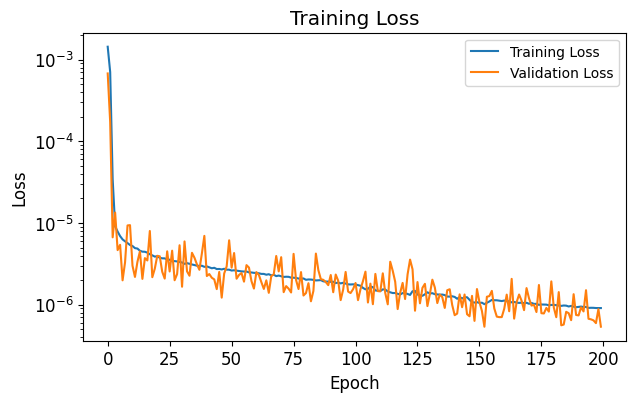

In [771]:
integrator = "midpoint"

(u_start, u_end, t_start, t_end, dt, u_ex), dudt, u_train,t, H0, u0s_train  =  generate_data(system=sys,ntrajectories =ntraj_train, t_sample = t_train,integrator=integrator)
train_data = (u_start, u_end, t_start, t_end, dt, u_ex), dudt

dt_val = T_max_val/nsamples_val
nt_val = round(T_max_val / dt_val)
t_val= np.linspace(0, T_max_val, nt_val + 1)

(u_start, u_end, t_start, t_end, dt, u_ex), dudt, u_val,t, H0, u0s_val =  generate_data(system=sys,ntrajectories =ntraj_val, t_sample = t_val,integrator=integrator)
val_data = (u_start, u_end, t_start, t_end, dt, u_ex), dudt
model_exp = PseudoHamiltonianNeuralNetwork(nstates = sys.nstates, S=sys.S,Hamiltonian_estimated = BaseHamiltonianNeuralNetwork(nstates=sys.nstates), initial_condition_sampler = initial_condition)


optimizer_exp = torch.optim.Adam(model_exp.parameters(), lr=lr)
model_exp, trainingdetails_explicit = train(model = model_exp,integrator = integrator, train_data = train_data, val_data = val_data,optimizer = optimizer_exp,shuffle=True, epochs = epochs)

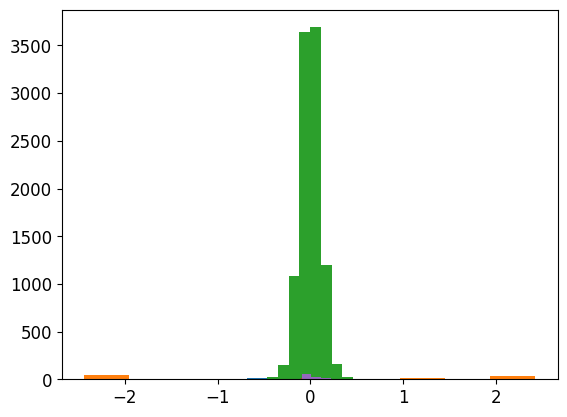

In [772]:
for param in model_exp.parameters():
  plt.hist(param.data.numpy().flatten())

### Predicting from Explicit Midpoint

100%|██████████| 1/1 [00:00<00:00, 55.04it/s]
/var/folders/hz/4gdmfnt15kl39xg3l41t9hr00000gn/T/ipykernel_26883/159804729.py:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  u0 = torch.tensor(u0,dtype = torch.float32)


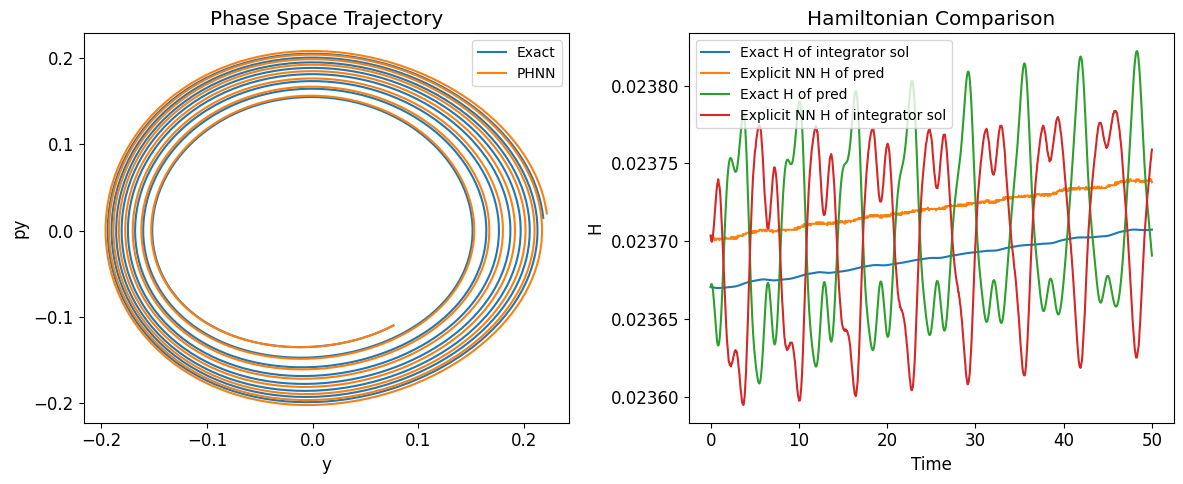

In [773]:
tmax = 50
nsamples = 1000
dt = tmax/nsamples

nt = round(tmax / dt)
t_sample = np.linspace(0, tmax, nt + 1)
ntrajectories = 1
integrator = "midpoint"

(u_start, u_end, t_start, t_end, dt, u_ex), dudt, u_exact,t, H0, u0s =  generate_data(system=sys,ntrajectories =ntrajectories, t_sample = t_sample,integrator=integrator)
u_exact = u_exact.squeeze(0)

u_phnn_exp, t_sample = model_exp.generate_trajectories(ntrajectories = ntrajectories, t_sample = t_sample,integrator = integrator,u0s=u0s)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))  
y, py = u_exact[:, 1], u_exact[:, 3]
ax[0].plot(y, py, label="Exact")
y, py = u_phnn_exp[0][:, 1], u_phnn_exp[0][:, 3]
ax[0].plot(y, py, label="PHNN")
ax[0].set_xlabel("y")
ax[0].set_ylabel("py")
ax[0].set_title("Phase Space Trajectory")
ax[0].legend()


H_exact = torch.tensor([sys.Hamiltonian(u) for u in u_exact])
t = t_sample.squeeze(0)
u_samples = u_phnn_exp.squeeze(0)

# Computed estimated Hamiltonian from values for prediction
H_exp_nn = torch.tensor([(model_exp.Hamiltonian(u) - model_exp.Hamiltonian(torch.tensor([[0., 0., 0., 0.]]))) for u in u_samples])

# Computed true Hamiltonian values for prediction
H_exact_pred = torch.tensor([sys.Hamiltonian(u) for u in u_samples])

#Computed NN Hamiltonian for exact
H_nn_exact = torch.tensor([(model_exp.Hamiltonian(torch.tensor(u, dtype = torch.float32)) - model_exp.Hamiltonian(torch.tensor([[0., 0., 0., 0.]]))) for u in u_exact])


ax[1].plot(t, H_exact, label="Exact H of integrator sol")
ax[1].plot(t, H_exp_nn, label="Explicit NN H of pred")
ax[1].plot(t, H_exact_pred, label="Exact H of pred")
ax[1].plot(t, H_nn_exact, label="Explicit NN H of integrator sol")
ax[1].set_xlabel("Time")
ax[1].set_ylabel("H")
ax[1].set_title("Hamiltonian Comparison")
ax[1].legend()


plt.tight_layout() 
plt.show()

## Symplectic Euler

100%|██████████| 200/200 [31:54<00:00,  9.57s/it, epoch=199, loss=2.12e-7]


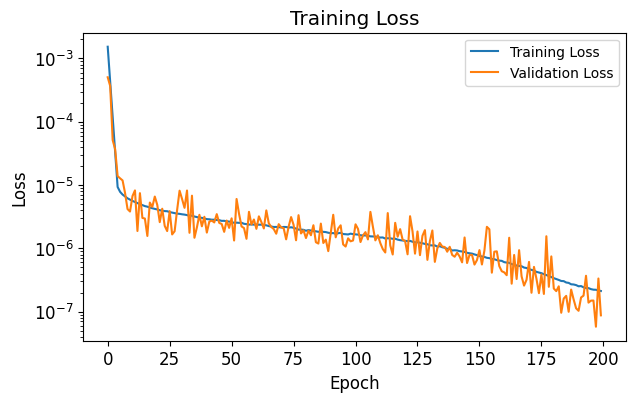

In [774]:
integrator = "symplectic euler"

(u_start, u_end, t_start, t_end, dt, u_ex), dudt, u_train,t, H0, u0s_train =  generate_data(system=sys,ntrajectories =ntraj_train, t_sample = t_train, integrator=integrator, u0s=u0s_train)
train_data = (u_start, u_end, t_start, t_end, dt, u_ex), dudt

dt_val = T_max_val/nsamples_val
nt_val = round(T_max_val / dt_val)
t_val= np.linspace(0, T_max_val, nt_val + 1)

(u_start, u_end, t_start, t_end, dt, u_ex), dudt, u_val,t, H0, u0s_val =  generate_data(system=sys,ntrajectories =ntraj_val, t_sample = t_val, integrator=integrator,  u0s=u0s_val)
val_data = (u_start, u_end, t_start, t_end, dt, u_ex), dudt

model_symp_eul = PseudoHamiltonianNeuralNetwork(nstates = sys.nstates, S=sys.S,Hamiltonian_estimated = BaseHamiltonianNeuralNetwork(nstates=sys.nstates), initial_condition_sampler = initial_condition)

optimizer_symp_eul = torch.optim.Adam(model_symp_eul.parameters(), lr=lr)
model_symp_eul, trainingdetails_symp_eul = train(model = model_symp_eul,integrator = integrator, train_data = train_data, val_data = val_data,optimizer = optimizer_symp_eul,shuffle=True, epochs = epochs)


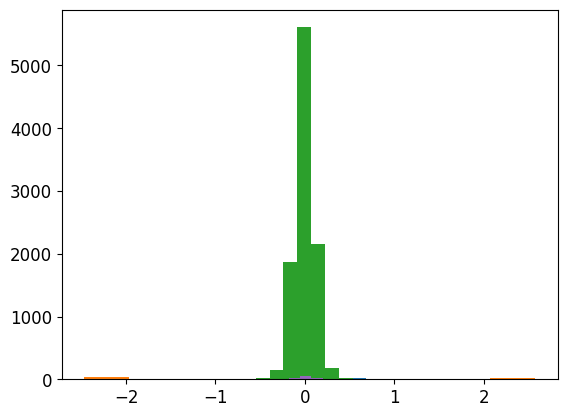

In [775]:
for param in model_symp_eul.parameters():
  plt.hist(param.data.numpy().flatten())

### Predicting from Symplectic Euler

100%|██████████| 1/1 [00:00<00:00, 61.57it/s]
/var/folders/hz/4gdmfnt15kl39xg3l41t9hr00000gn/T/ipykernel_26883/159804729.py:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  u0 = torch.tensor(u0,dtype = torch.float32)


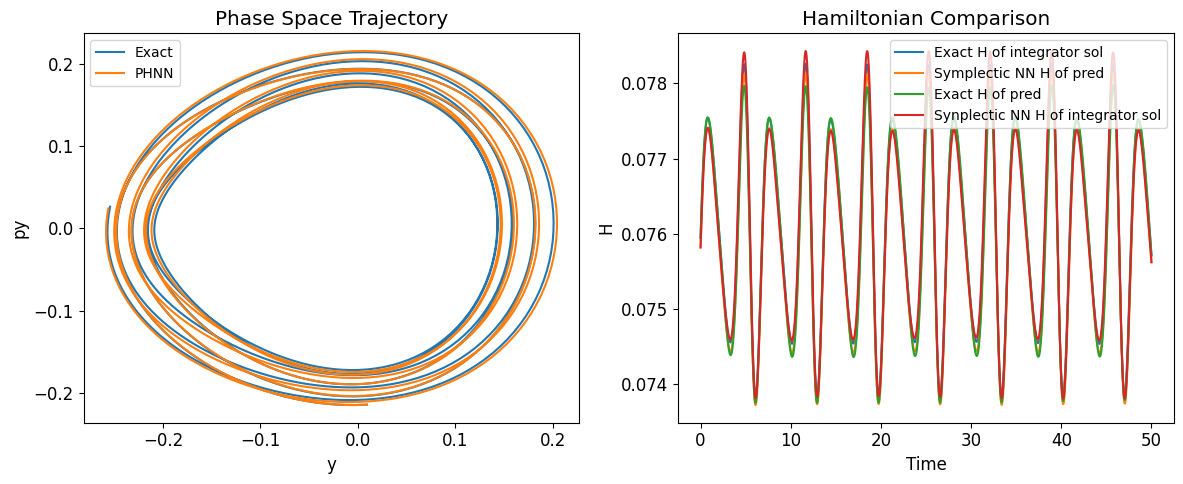

In [776]:
tmax = 50
nsamples = 1000
dt = tmax/nsamples

nt = round(tmax / dt)
t_sample = np.linspace(0, tmax, nt + 1)

ntrajectories = 1
integrator = "symplectic euler"

(u_start, u_end, t_start, t_end, dt, u_ex), dudt, u_exact,t, H0, u0s =  generate_data(system=sys,ntrajectories =ntrajectories, t_sample = t_sample,integrator=integrator)

u_phnn_symp, t_sample = model_symp_eul.generate_trajectories(ntrajectories = ntrajectories, t_sample = t_sample,integrator = integrator,u0s=u0s)


fig, ax = plt.subplots(1, 2, figsize=(12, 5))  
y, py = u_exact[0][:, 1], u_exact[0][:, 3]
ax[0].plot(y, py, label="Exact")
y, py = u_phnn_symp[0][:, 1], u_phnn_symp[0][:, 3]
ax[0].plot(y, py, label="PHNN")
ax[0].set_xlabel("y")
ax[0].set_ylabel("py")
ax[0].set_title("Phase Space Trajectory")
ax[0].legend()


H_exact = torch.tensor([sys.Hamiltonian(u) for u in u_exact.squeeze(0)])

t = t_sample.squeeze(0)
u_samples = u_phnn_symp.squeeze(0)
#Computed estimated Hamiltonian from values for prediction
H_symp_nn= torch.tensor([(model_symp_eul.Hamiltonian(u)- model_symp_eul.Hamiltonian(torch.tensor([[0.,  0.,  0.,  0.]])) )for u in u_samples])
#Computed true Hamiltonian values for prediction
H_exact_pred = torch.tensor([sys.Hamiltonian(u) for u in u_samples])
#Computed NN Hamiltonian for exact
H_nn_exact = torch.tensor([(model_symp_eul.Hamiltonian(torch.tensor(u, dtype = torch.float32)) - model_symp_eul.Hamiltonian(torch.tensor([[0., 0., 0., 0.]]))) for u in u_exact.squeeze(0)])


ax[1].plot(t, H_exact, label="Exact H of integrator sol")
ax[1].plot(t, H_symp_nn, label="Symplectic NN H of pred")
ax[1].plot(t, H_exact_pred, label="Exact H of pred")
ax[1].plot(t, H_nn_exact, label="Synplectic NN H of integrator sol")
ax[1].set_xlabel("Time")
ax[1].set_ylabel("H")
ax[1].set_title("Hamiltonian Comparison")
ax[1].legend()


plt.tight_layout() 
plt.show()

## Symplectic Midpoint

100%|██████████| 200/200 [16:00<00:00,  4.80s/it, epoch=199, loss=4.59e-7]


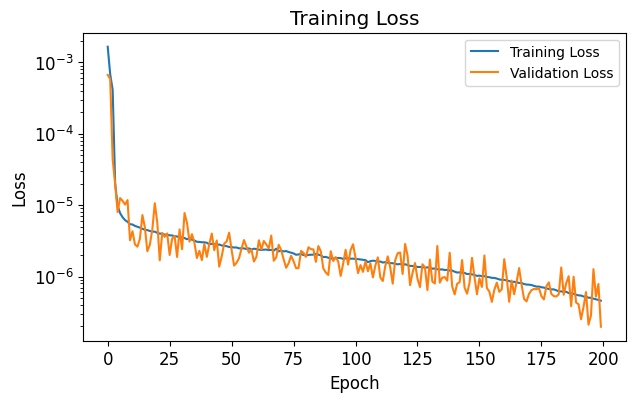

In [777]:
integrator = "symplectic midpoint"

(u_start, u_end, t_start, t_end, dt, u_ex), dudt, u_train,t, H0, u0s_train =  generate_data(system=sys,ntrajectories =ntraj_train, t_sample = t_train, integrator=integrator, u0s=u0s_train)
train_data = (u_start, u_end, t_start, t_end, dt, u_ex), dudt

dt_val = T_max_val/nsamples_val
nt_val = round(T_max_val / dt_val)
t_val= np.linspace(0, T_max_val, nt_val + 1)

(u_start, u_end, t_start, t_end, dt, u_ex), dudt, u_val,t, H0, u0s_val =  generate_data(system=sys,ntrajectories =ntraj_val, t_sample = t_val, integrator=integrator,  u0s=u0s_val)
val_data = (u_start, u_end, t_start, t_end, dt, u_ex), dudt

model_symp = PseudoHamiltonianNeuralNetwork(nstates = sys.nstates, S=sys.S,Hamiltonian_estimated = BaseHamiltonianNeuralNetwork(nstates=sys.nstates), initial_condition_sampler = initial_condition)

optimizer_symp = torch.optim.Adam(model_symp.parameters(), lr=lr)
model_symp, trainingdetails_symp = train(model = model_symp,integrator = integrator, train_data = train_data, val_data = val_data,optimizer = optimizer_symp,shuffle=True, epochs = epochs)


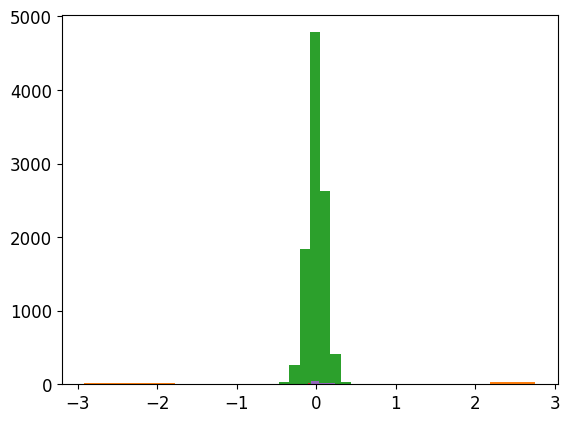

In [778]:
for param in model_symp.parameters():
  plt.hist(param.data.numpy().flatten())

### Predicting from Symplectic Midpoint

100%|██████████| 1/1 [00:00<00:00,  6.22it/s]
/var/folders/hz/4gdmfnt15kl39xg3l41t9hr00000gn/T/ipykernel_26883/159804729.py:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  u0 = torch.tensor(u0,dtype = torch.float32)
/var/folders/hz/4gdmfnt15kl39xg3l41t9hr00000gn/T/ipykernel_26883/57532489.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  guess = torch.tensor(guess, dtype=torch.float32, requires_grad=True)


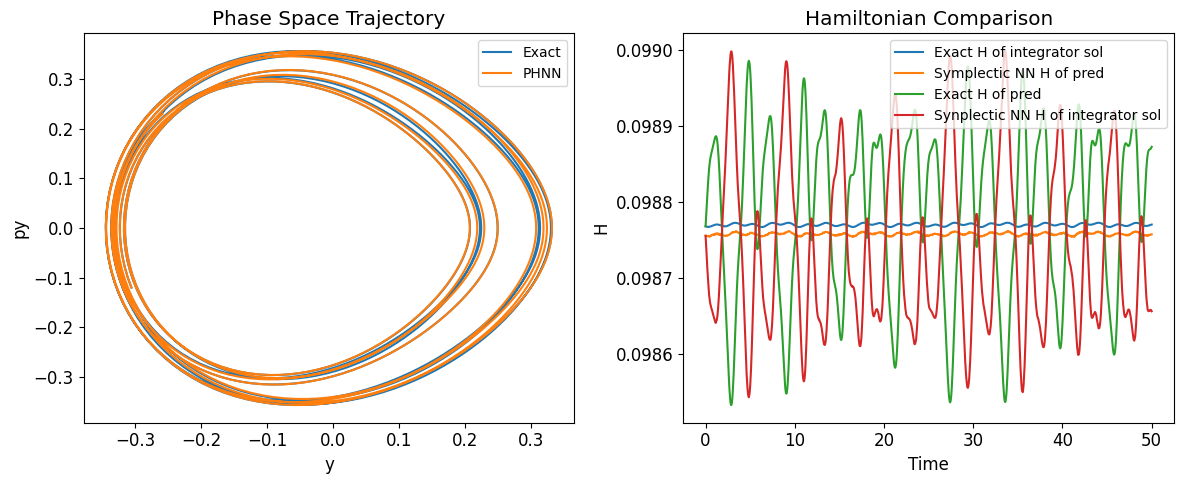

In [779]:
tmax = 50
nsamples = 1000
dt = tmax/nsamples

nt = round(tmax / dt)
t_sample = np.linspace(0, tmax, nt + 1)

ntrajectories = 1
integrator = "symplectic midpoint"

(u_start, u_end, t_start, t_end, dt, u_ex), dudt, u_exact,t, H0, u0s =  generate_data(system=sys,ntrajectories =ntrajectories, t_sample = t_sample,integrator=integrator)

u_phnn_symp, t_sample = model_symp.generate_trajectories(ntrajectories = ntrajectories, t_sample = t_sample,integrator = integrator,u0s=u0s)


fig, ax = plt.subplots(1, 2, figsize=(12, 5))  
y, py = u_exact[0][:, 1], u_exact[0][:, 3]
ax[0].plot(y, py, label="Exact")
y, py = u_phnn_symp[0][:, 1], u_phnn_symp[0][:, 3]
ax[0].plot(y, py, label="PHNN")
ax[0].set_xlabel("y")
ax[0].set_ylabel("py")
ax[0].set_title("Phase Space Trajectory")
ax[0].legend()


H_exact = torch.tensor([sys.Hamiltonian(u) for u in u_exact.squeeze(0)])
t = t_sample.squeeze(0)
u_samples = u_phnn_symp.squeeze(0)
#Computed estimated Hamiltonian from values for prediction
H_symp_nn= torch.tensor([(model_symp.Hamiltonian(u)- model_symp.Hamiltonian(torch.tensor([[0.,  0.,  0.,  0.]])) )for u in u_samples])
#Computed true Hamiltonian values for prediction
H_exact_pred = torch.tensor([sys.Hamiltonian(u) for u in u_samples])

#Computed NN Hamiltonian for exact
H_nn_exact = torch.tensor([(model_symp.Hamiltonian(torch.tensor(u, dtype = torch.float32)) - model_symp.Hamiltonian(torch.tensor([[0., 0., 0., 0.]]))) for u in u_exact.squeeze(0)])


ax[1].plot(t, H_exact, label="Exact H of integrator sol")
ax[1].plot(t, H_symp_nn, label="Symplectic NN H of pred")
ax[1].plot(t, H_exact_pred, label="Exact H of pred")
ax[1].plot(t, H_nn_exact, label="Synplectic NN H of integrator sol")
ax[1].set_xlabel("Time")
ax[1].set_ylabel("H")
ax[1].set_title("Hamiltonian Comparison")
ax[1].legend()


plt.tight_layout() 
plt.show()

## Predicting rhs of ODE

In [ ]:
def learned_hnn_f(u,model=model_symp, sys = HenonHeilesSystem()):
    """Calculates the lhs of the ODE for a given point u"""
    H = model.Hamiltonian(u)
    dH = torch.autograd.grad(H.sum(), u, retain_graph=False, create_graph=False)[0]
    S = torch.tensor(sys.S,dtype=torch.float32)
    u = u.view(-1)
    dH = dH.view(-1, 1)
    SdH = S@dH
    return SdH.flatten().detach().numpy()

## Saving models

In [780]:
torch.save(model_exp,"Models/model_exp_200epoch_softplus_sin.pt")
torch.save(model_symp_eul,"Models/model_symp_eul_200epoch_softplus_sin.pt")
torch.save(model_symp,"Models/model_symp_200epoch_softplus_sin.pt")

## Loading models

In [ ]:
model_symp = torch.load("Models/model_symp_200epoch_softplus_sin.pt", weights_only=False)
model_symp.eval()